In [1]:
from walidacja_funkcji import *
import torch
import torch.nn as nn
import torch.optim as optim
from scipy import stats

In [3]:
def reinit_model(model):
    """Reinicjalizuje wagi modelu"""
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)

def fast_kl_jsd_2d(real_data, fake_data, bins=50):
    all_data = np.vstack([real_data, fake_data])
    range_2d = [(all_data[:, i].min(), all_data[:, i].max()) for i in range(all_data.shape[1])]
    
    # Histogramy w jednej operacji
    P, _ = np.histogramdd(real_data, bins=bins, range=range_2d, density=True)
    Q, _ = np.histogramdd(fake_data, bins=bins, range=range_2d, density=True)
    
    # Normalizacja do prawdopodobieństw
    P = P / P.sum()
    Q = Q / Q.sum()
    
    # Epsilon dla stabilności numerycznej
    epsilon = 1e-8
    P += epsilon
    Q += epsilon
    
    # KL divergence: KL(Q||P) - fake vs real
    kl_divergence = np.sum(Q * np.log(Q / P))
    
    # JSD: 0.5 * [KL(P||M) + KL(Q||M)], gdzie M = (P+Q)/2
    M = (P + Q) / 2 + epsilon
    
    kl_pm = np.sum(P * np.log(P / M))
    kl_qm = np.sum(Q * np.log(Q / M))
    jsd = 0.5 * (kl_pm + kl_qm)
    
    return kl_divergence, jsd

In [4]:
prober = rs_prober_NKG(epsilon=0.1, looking_x_left=-1, looking_x_right=1, from_x=0)

def get_2d_data(PROBE_SIZE: int):
    rs = prober.rejection_sampling(length=PROBE_SIZE // 2)
    theta = np.random.uniform(0, 2*np.pi, size=PROBE_SIZE // 2)
    xs = rs * np.cos(theta)
    ys = rs * np.sin(theta)
    return np.vstack([xs, ys])

In [7]:
def plot_basic_stats(generator_losses, discriminator_losses, KL, JSD, Wasserstein_distance, epoch, extra_label=''):
    # plt.ioff()
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(15, 15))
    SAMPLE_LENGTH = GENERATOR_SAMPLES_TO_RETURN * 10000
    ROI = np.array([[-5, 5], [-5, 5]])
    epoch_range = np.arange(epoch)
    markersize = min(2000 / len(epoch_range), 10)
    
    gen_color = '#1f77b4'     # Matplotlib blue
    disc_color = '#d62728'    # Matplotlib red
    x_color = '#ff7f0e'       # Matplotlib orange
    y_color = '#2ca02c'       # Matplotlib green
    theory = '#9467bd'        # Matplotlib purple

    # Get data
    x_true, y_true = get_2d_data(SAMPLE_LENGTH)
    noise = torch.randn(SAMPLE_LENGTH // GENERATOR_SAMPLES_TO_RETURN, NOISE_SIZE).cuda()
    x_fake, y_fake = generator.layers(noise).detach().reshape(-1, 2).cpu().numpy().T

    # Histograms
    hist_true, _, _ = np.histogram2d(x_true, y_true, bins=500, range=ROI)
    hist_fake, _, _ = np.histogram2d(x_fake, y_fake, bins=500, range=ROI)
    
    # Plot 1-2: 2D histograms
    for ax, hist, title in [(ax1, hist_fake, 'Generator'), (ax2, hist_true, 'NKG Metropolis')]:
        im = ax.imshow(np.log10(hist + 1).T, extent=ROI.flatten(), aspect='auto')
        ax.set_title(f'Rzeczywisty rozklad\n$log_{{10}}$(Liczby czastek) dla {title}')
        ax.set_xlabel('x [m]')
        ax.set_ylabel('y [m]')
        plt.colorbar(im, ax=ax)

    # Plot 3: Losses
    ax3.set_title(f'Logarytm strat, lr_gen={generator.optim.param_groups[0]["lr"]:.2e}\n lr_dis={discriminator.optim.param_groups[0]["lr"]:.2e}')
    ax3.plot(epoch_range, np.log10(discriminator_losses[:epoch] + 1e-12), 'o', markersize=markersize, label='dyskryminator', color=disc_color)
    ax3.plot(epoch_range, np.log10(generator_losses[:epoch] + 1e-12), 'o', markersize=markersize, label='generator', color=gen_color)
    ax3.legend(markerscale=1.5/markersize)
    ax3.set_xlabel('Epoka')
    ax3.set_ylabel(r'$log_{10}$(strata)')
    
    # Plot 4: KL, JSD, Wasserstein
    ax4.set_title('Metryki rozbieznosci')
    ax4.plot(epoch_range, np.log10(Wasserstein_distance[:epoch] + 1e-12), 'o', markersize=markersize, color='green', label='Wasserstein')
    ax4.plot(epoch_range, np.log10(KL[:epoch] + 1e-12), 'o', markersize=markersize, color='blue', label='KL')
    ax4_twin = ax4.twinx()
    ax4_twin.plot(epoch_range, np.log10(JSD[:epoch] + 1e-12), 'o', markersize=markersize, color='red', label='JSD')
    ax4.set_ylabel('$log_{10}$(KL, Wasserstein)', color='blue')
    ax4_twin.set_ylabel('$log_{10}$(JSD)', color='red')
    ax4.set_xlabel('Epoka')
    ax4.legend(markerscale=1.5/markersize, loc='upper left')
    ax4_twin.legend(markerscale=1.5/markersize, loc='upper right')

    # Plot 5: R distribution
    r_true, r_fake = np.sqrt(x_true**2 + y_true**2), np.sqrt(x_fake**2 + y_fake**2)
    r_bins = np.linspace(r_true.min(), r_true.max(), 100)
    ax5.hist(r_true, bins=r_bins, label='Rejection sampling', color=theory, alpha=0.7, edgecolor='white', linewidth=0.5)
    ax5.hist(r_fake, bins=r_bins, label='Generator', alpha=0.6, color=gen_color, edgecolor='white', linewidth=0.5)
    ax5.set_title('Rozklad r')
    ax5.set_xlabel('r [m]')
    ax5.set_ylabel('Liczba probek')
    ax5.legend()

    # Plot 6: X,Y distributions
    bins = np.linspace(-5, 5, 100)
    ax6.hist(x_fake, bins=bins, label=r'$x_{Fake}$', alpha=0.95, color=x_color, edgecolor='white', linewidth=0.5)
    ax6.hist(y_fake, bins=bins, label=r'$y_{Fake}$', alpha=0.80, color=y_color, edgecolor='white', linewidth=0.5)
    ax6.hist(x_true, bins=bins, label=r'$x_{True}$', alpha=0.65, color=theory, edgecolor='white', linewidth=0.5)
    ax6.hist(y_true, bins=bins, label=r'$y_{True}$', alpha=0.25, color='#8B4513', edgecolor='white', linewidth=0.5)  # Saddle Brown zamiast czarnego
    ax6.set_xlabel('Wartosc wspolrzednej x lub y')
    ax6.set_ylabel('Liczba probek')
    ax6.set_title('Rozklady wspolrzednych')
    ax6.legend()

    bin_width = 20 / BINS
    centers = -10 + (torch.arange(BINS) + 0.5) * bin_width
    fake_histogram_np = fake_histogram.squeeze().sum(dim=0).detach().cpu().numpy()
    true_histogram_np = true_histogram.squeeze().sum(dim=0).detach().cpu().numpy()
    
    # Plot 7: Standard deviation
    ax7.set_title('Histogram podrobionych probek\nktory widzi dyskryminator')
    im = ax7.imshow(fake_histogram_np, extent=[-10, 10, -10, 10])
    ax7.set_xlabel('x')
    ax7.set_ylabel('y')
    plt.colorbar(im, ax=ax7)

    # Plot 8: Standard deviation
    ax8.set_title('Histogram prawdziwego rozkladu\nktory widzi dyskryminator')
    im = ax8.imshow(true_histogram_np, extent=[-10, 10, -10, 10])
    ax8.set_xlabel('x')
    ax8.set_ylabel('y')
    plt.colorbar(im, ax=ax8)
    
    # Plot 9: srednia kwadratow
    ax9.set_title('Roznica miedzy histogramami\nabs(fake_histogram - true_histogram)')
    im = ax9.imshow(np.abs(true_histogram_np - fake_histogram_np), extent=[-10, 10, -10, 10])
    ax9.set_xlabel('x')
    ax9.set_ylabel('y')
    plt.colorbar(im, ax=ax9)

    # Statistics
    r_pearson = np.log10(1 - np.corrcoef(np.sort(r_true), np.sort(r_fake))[0, 1])
    x_pearson = np.log10(1 - np.corrcoef(np.sort(x_true), np.sort(x_fake))[0, 1])
    y_pearson = np.log10(1 - np.corrcoef(np.sort(y_true), np.sort(y_fake))[0, 1])

    # Fixed text positioning - move higher to avoid cutting
    fig.text(0.5, 0.97, f'{EPOCHS=}, {LR_CONSTANT=}, {LR_RATIO=}, {BATCH_SIZE=}', ha='center', fontsize=16)
    fig.text(0.5, 0.945, f'{GENERATOR_SAMPLES_TO_RETURN=}, {BINS=}', ha='center', fontsize=16)
    fig.text(0.5, 0.92, rf'$log_{{10}}$(1-$\rho_{{r, Pearson}}$) = {r_pearson:.3f}, $log_{{10}}$(1-$\rho_{{x, Pearson}}$) = {x_pearson:.3f}, $log_{{10}}$(1-$\rho_{{y, Pearson}}$) = {y_pearson:.3f}', ha='center', fontsize=16)
    
    # Adjust layout with proper spacing for text
    plt.tight_layout(rect=[0, 0.02, 1, 0.91])  # Leave more space at top
    plt.savefig(f'./Wykresy/Moj_NKG/podsumowanie{extra_label}.jpg', dpi=150, bbox_inches='tight')
    # plt.show()
    # plt.close()

# plot_basic_stats(generator_losses, discriminator_losses, KL, JSD, Wasserstein_distance, EPOCHS, f'\nTrening_dla_{EPOCHS=}')

In [8]:
"""
    Generator z szumu bedzie dawac x i y - ale czy ja powinienem mu przeslac informacje o zakresie w jakim ma generowac x ?
"""

class Generator(nn.Module):
    def __init__(self, layers: list, lr: float = 1e-5):
        super().__init__()
        self.layers = nn.Sequential(*layers)
        self.optim = optim.Adam(self.parameters(), lr, betas=(0.5, 0.999)) # consider other options
        self.loss = nn.MSELoss()
        self = self.to('cuda')

    def training_step(self, noise): # OPTIMIZE - would be nice to send here the data - instead of generating it
        self.zero_grad()
        fake_data = generator.layers(noise).reshape(BATCH_SIZE, -1, 2)
        fake_histogram = soft_histogram(fake_data, min_value=-10, max_value=10, bins=BINS)
        
        fake_labels = discriminator.layers(fake_histogram)
        
        gen_loss = self.loss(fake_labels, torch.ones_like(fake_labels))
        gen_loss.backward()
        
        gen_loss = gen_loss.detach().cpu().item()
        
        self.optim.step()
        
        return gen_loss

In [9]:
"""
    Dyskriminator tak jak zwykle bierze input i zwraca czy prawdziwy czy nie
"""

class Discriminator(nn.Module):
    def __init__(self, layers: list, lr: float = 1e-5):
        super().__init__()
        self.layers = nn.Sequential(*layers)
        self.optim = optim.Adam(self.parameters(), lr, betas=(0.5, 0.999))
        self.loss = nn.MSELoss()
        self = self.to('cuda')

    def training_step(self, true_histogram, fake_histogram, steps = 1):
        for _ in range(steps):
            self.optim.zero_grad()
            
            y_true = self.layers(true_histogram)
            loss_true = self.loss(y_true, torch.ones_like(y_true).cuda())
            
            y_fake = self.layers(fake_histogram)
            loss_fake = self.loss(y_fake, torch.zeros_like(y_fake).cuda())
            
            loss = (loss_true + loss_fake)
            loss.backward()
            loss = loss.detach().item()
            
            self.optim.step()
            
        return loss

Trening [████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████] 4999/5000
(100.0%)

1326 Epok / min


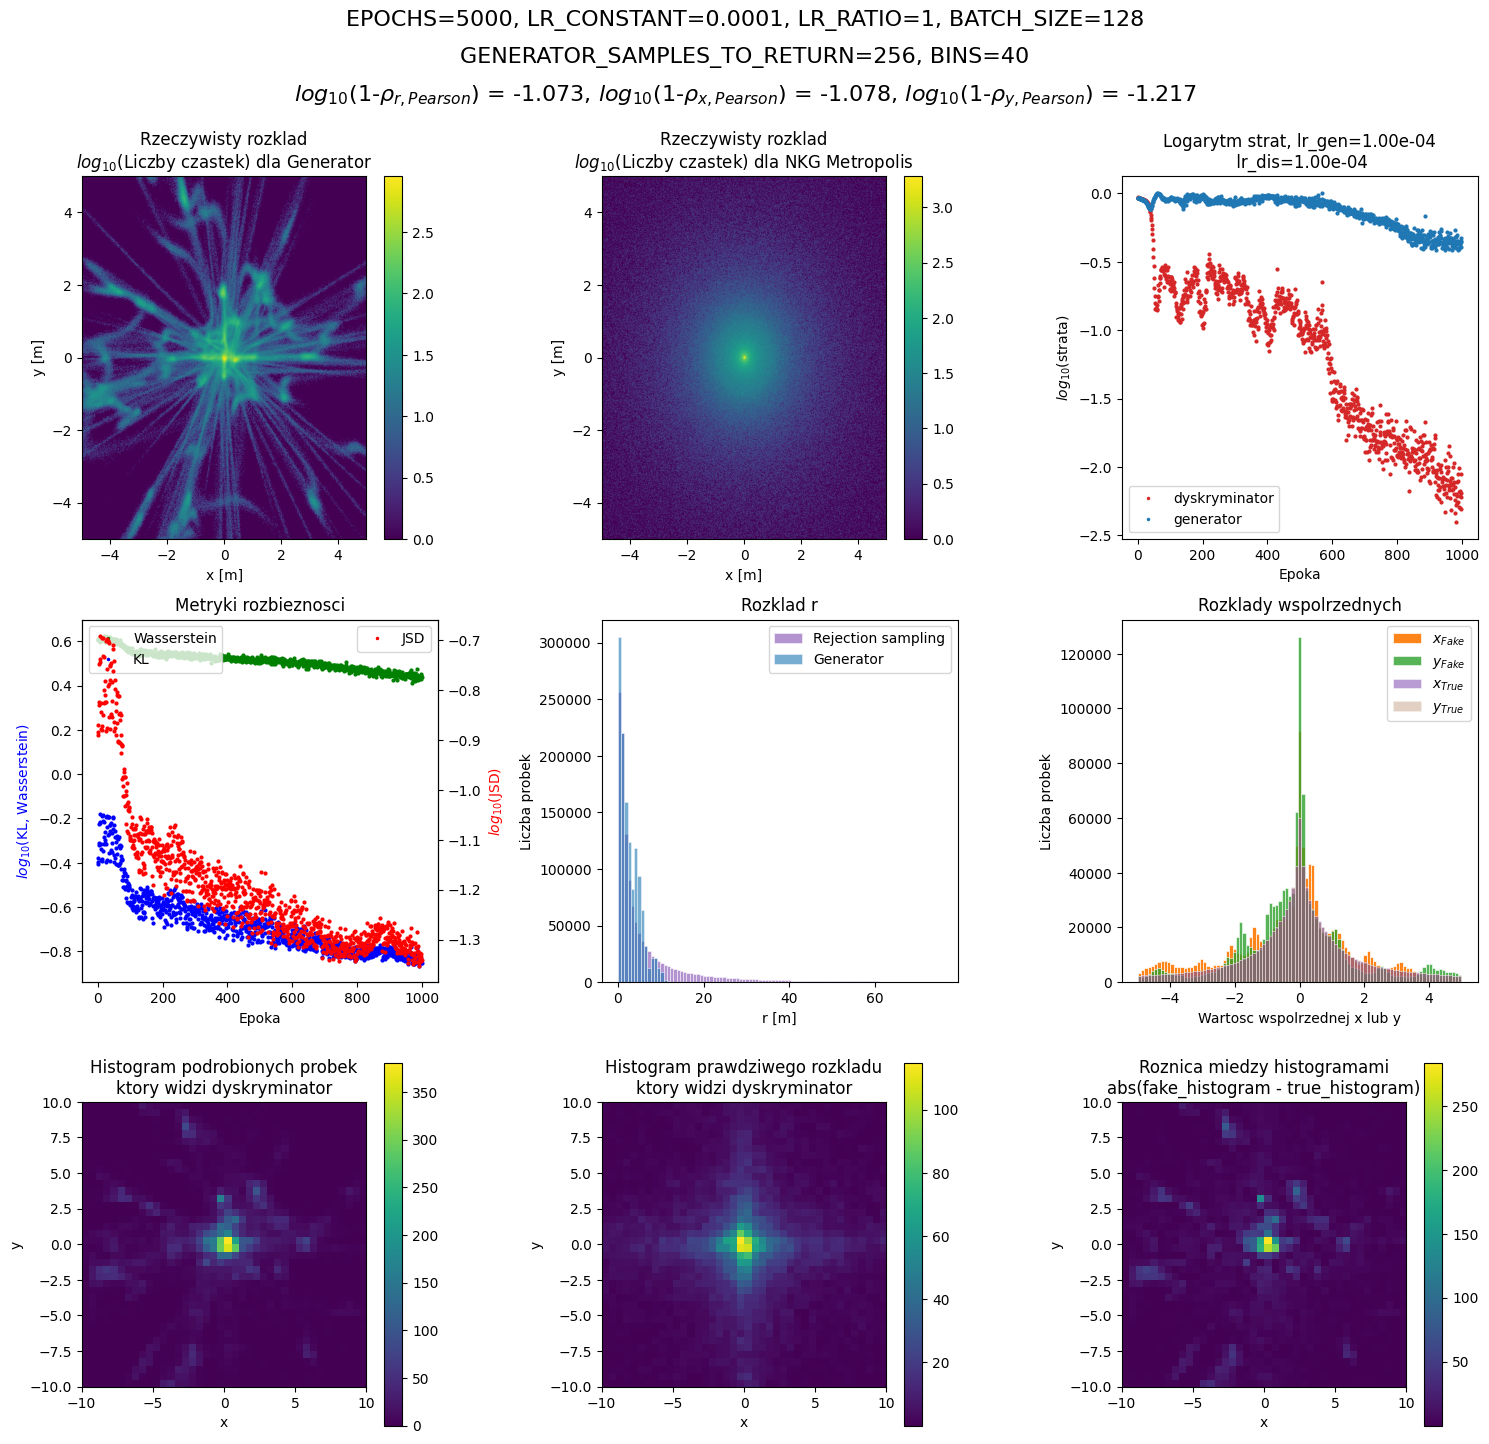

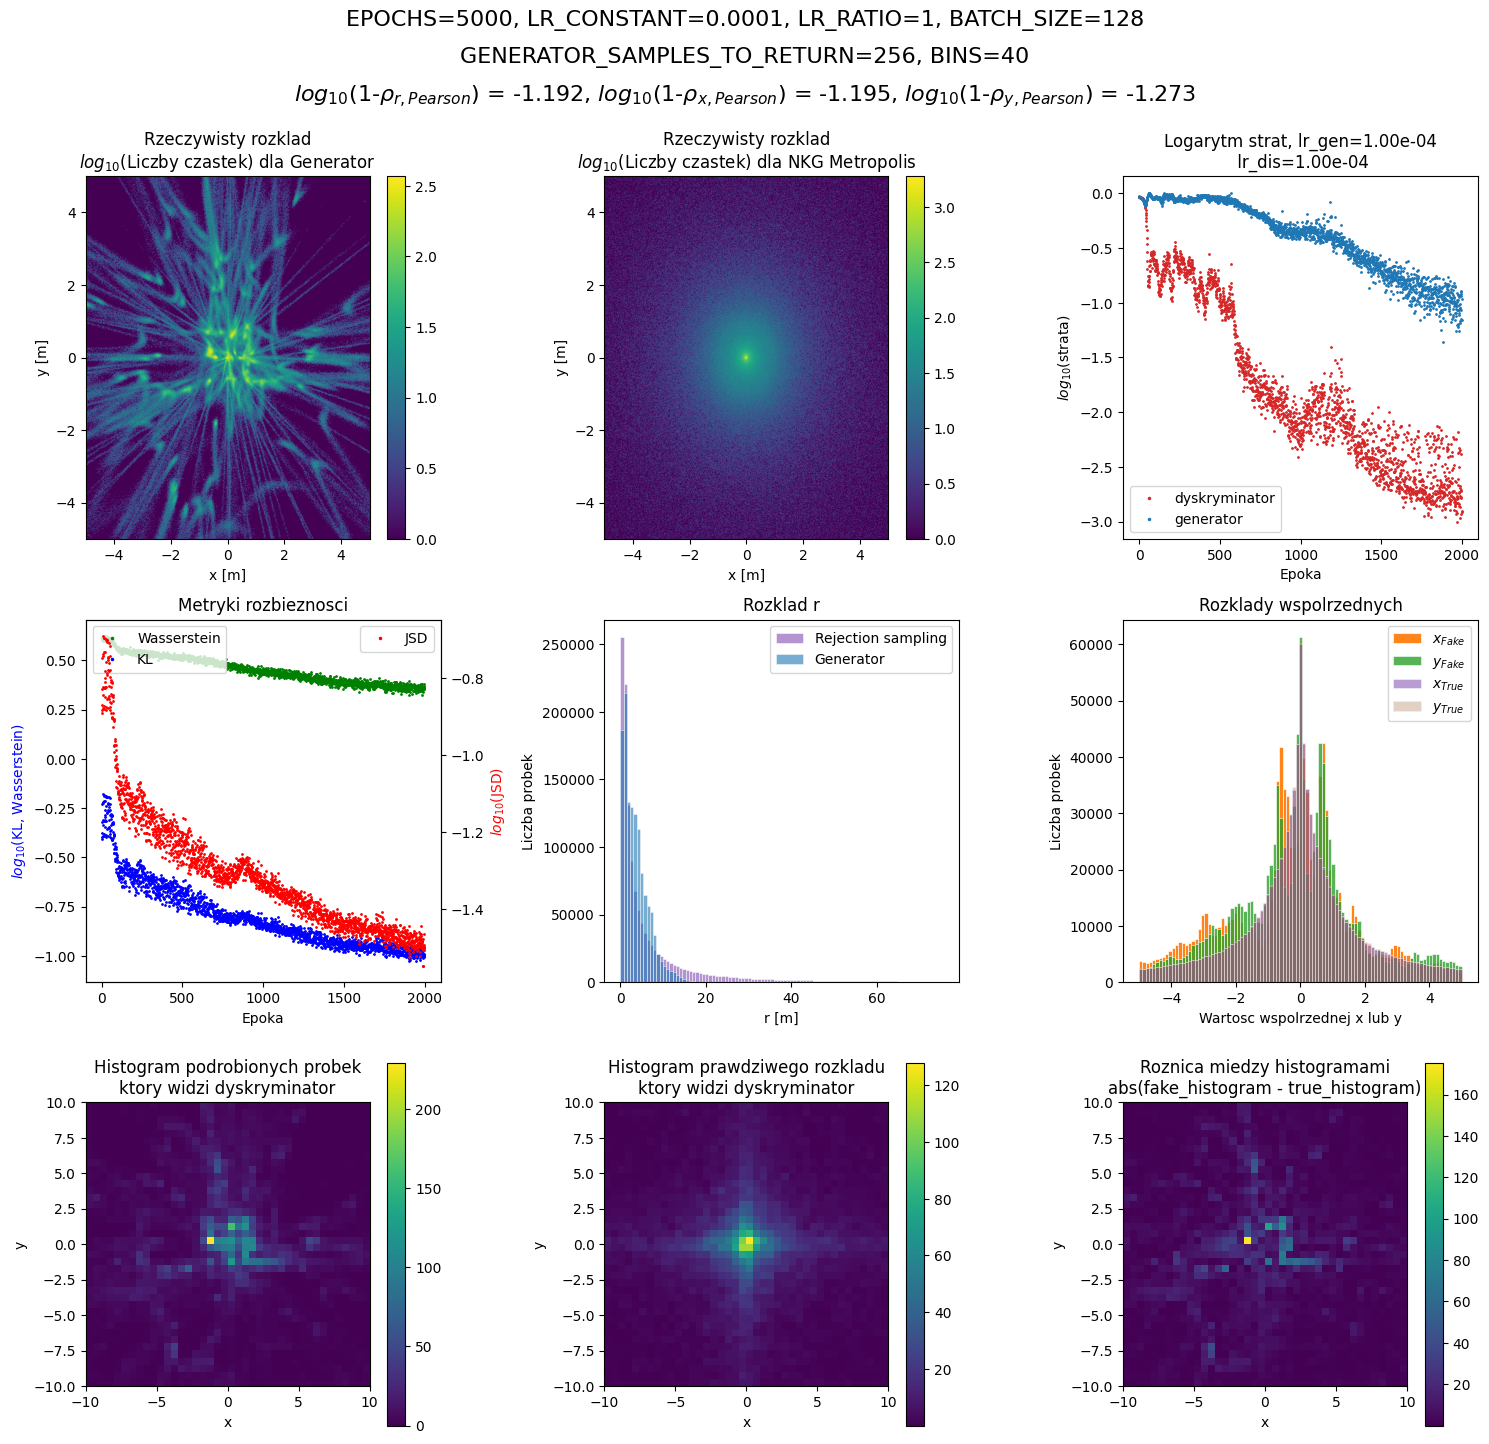

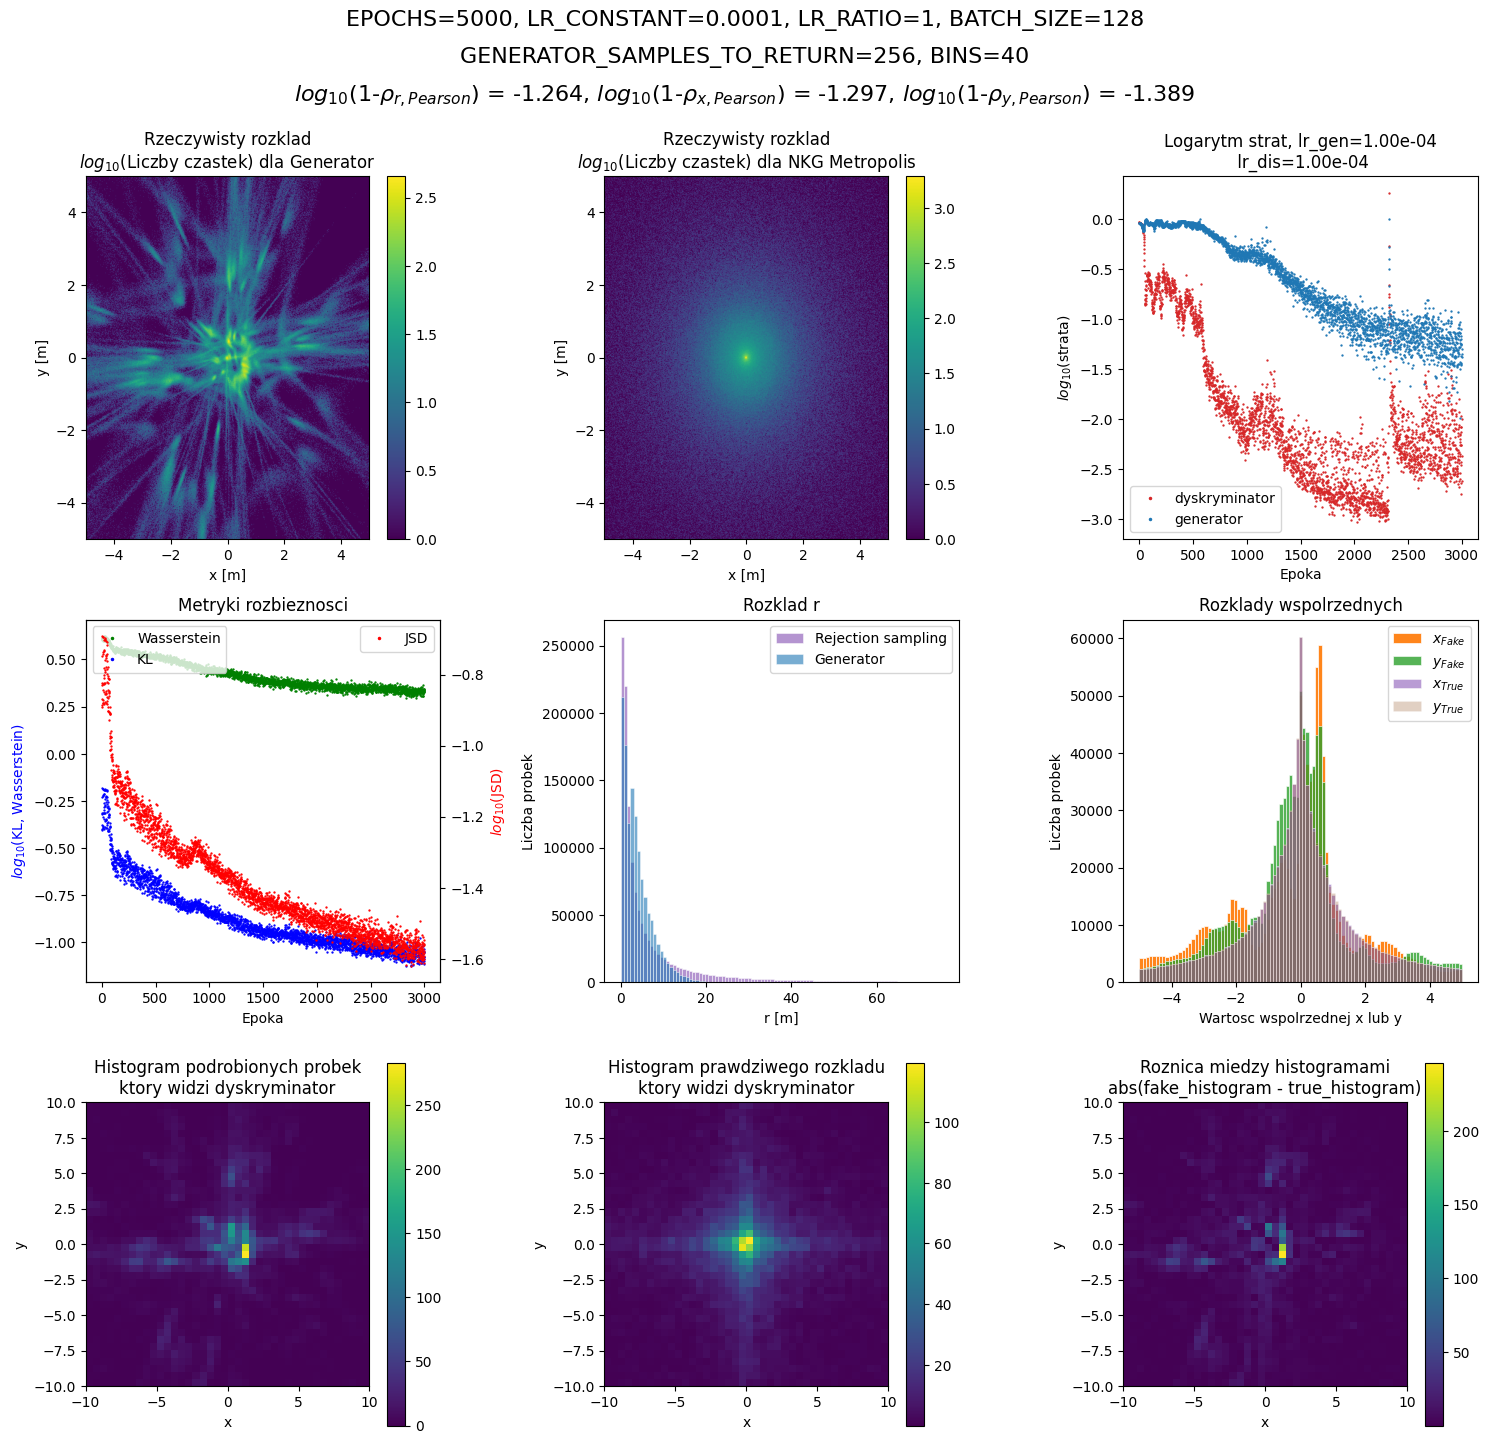

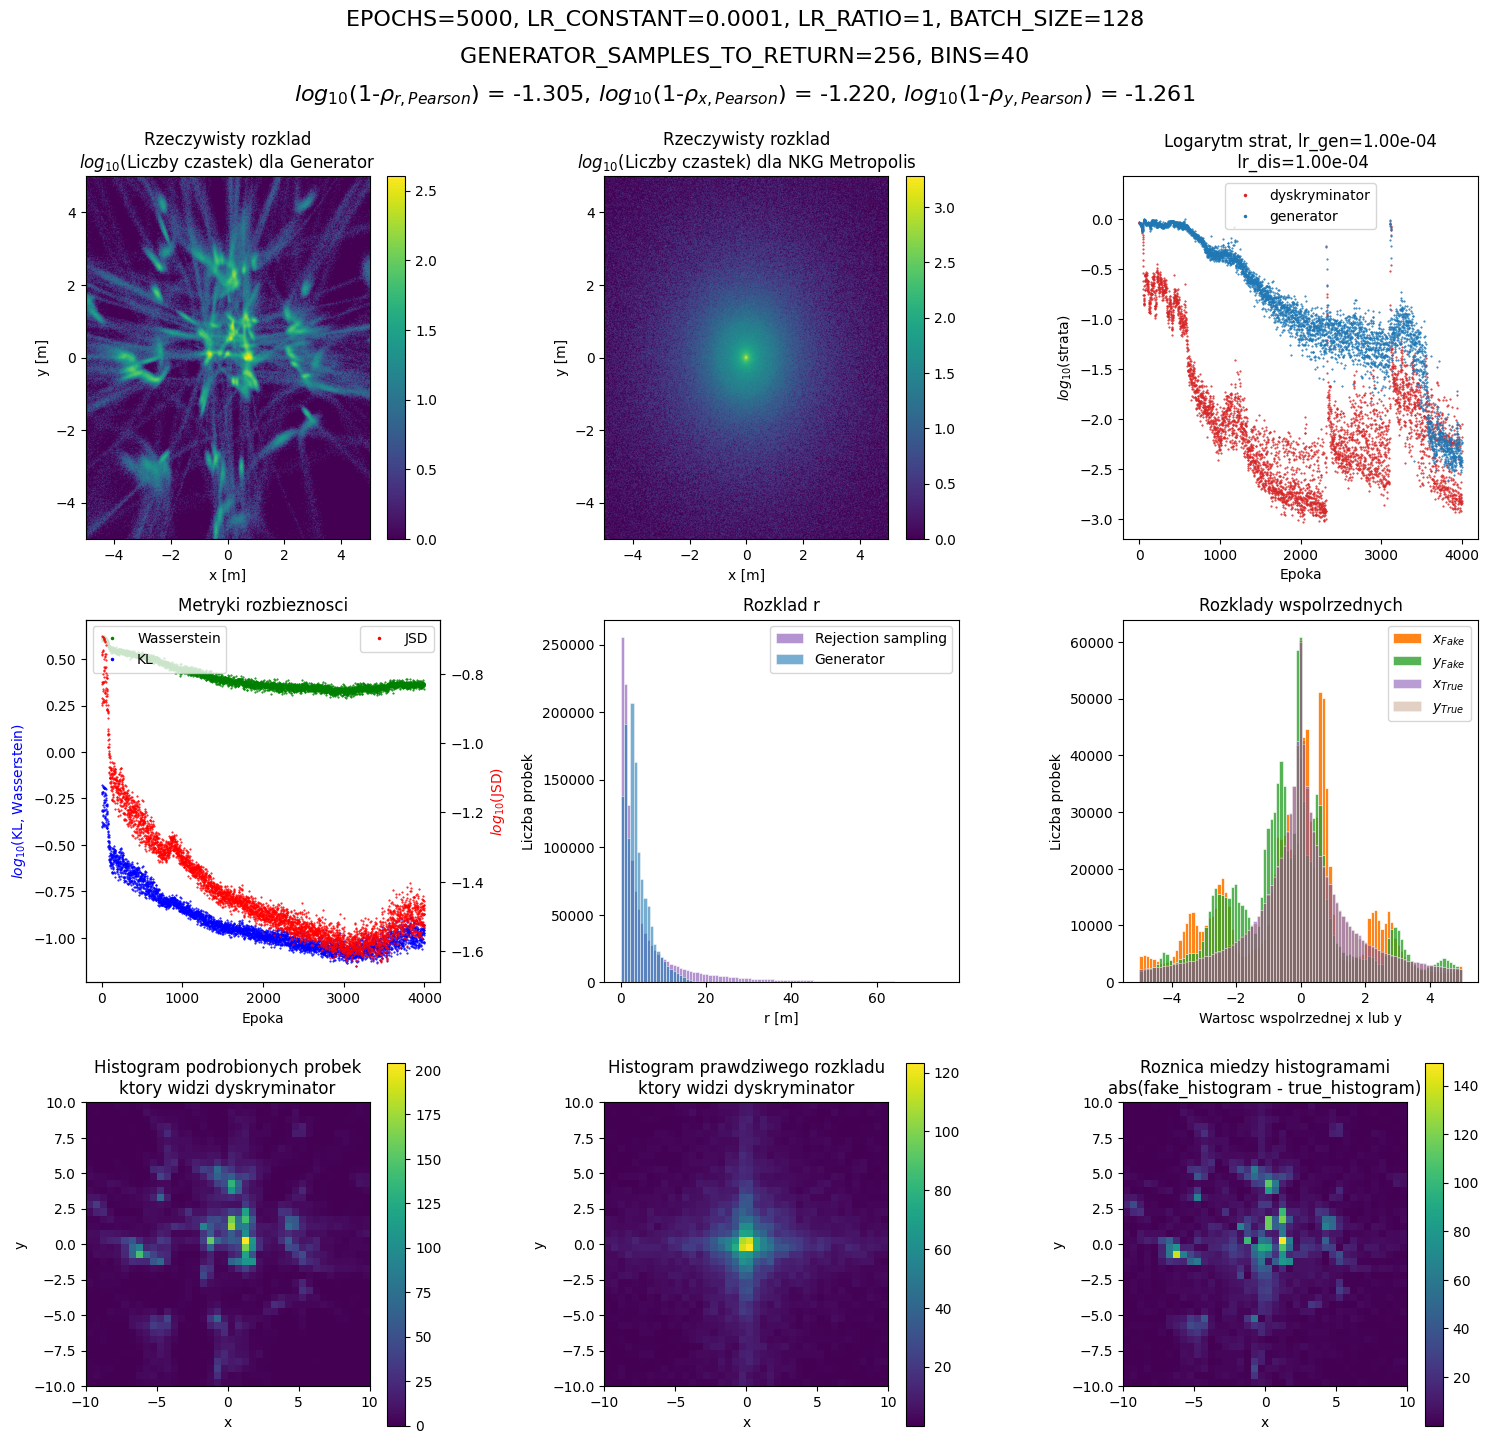

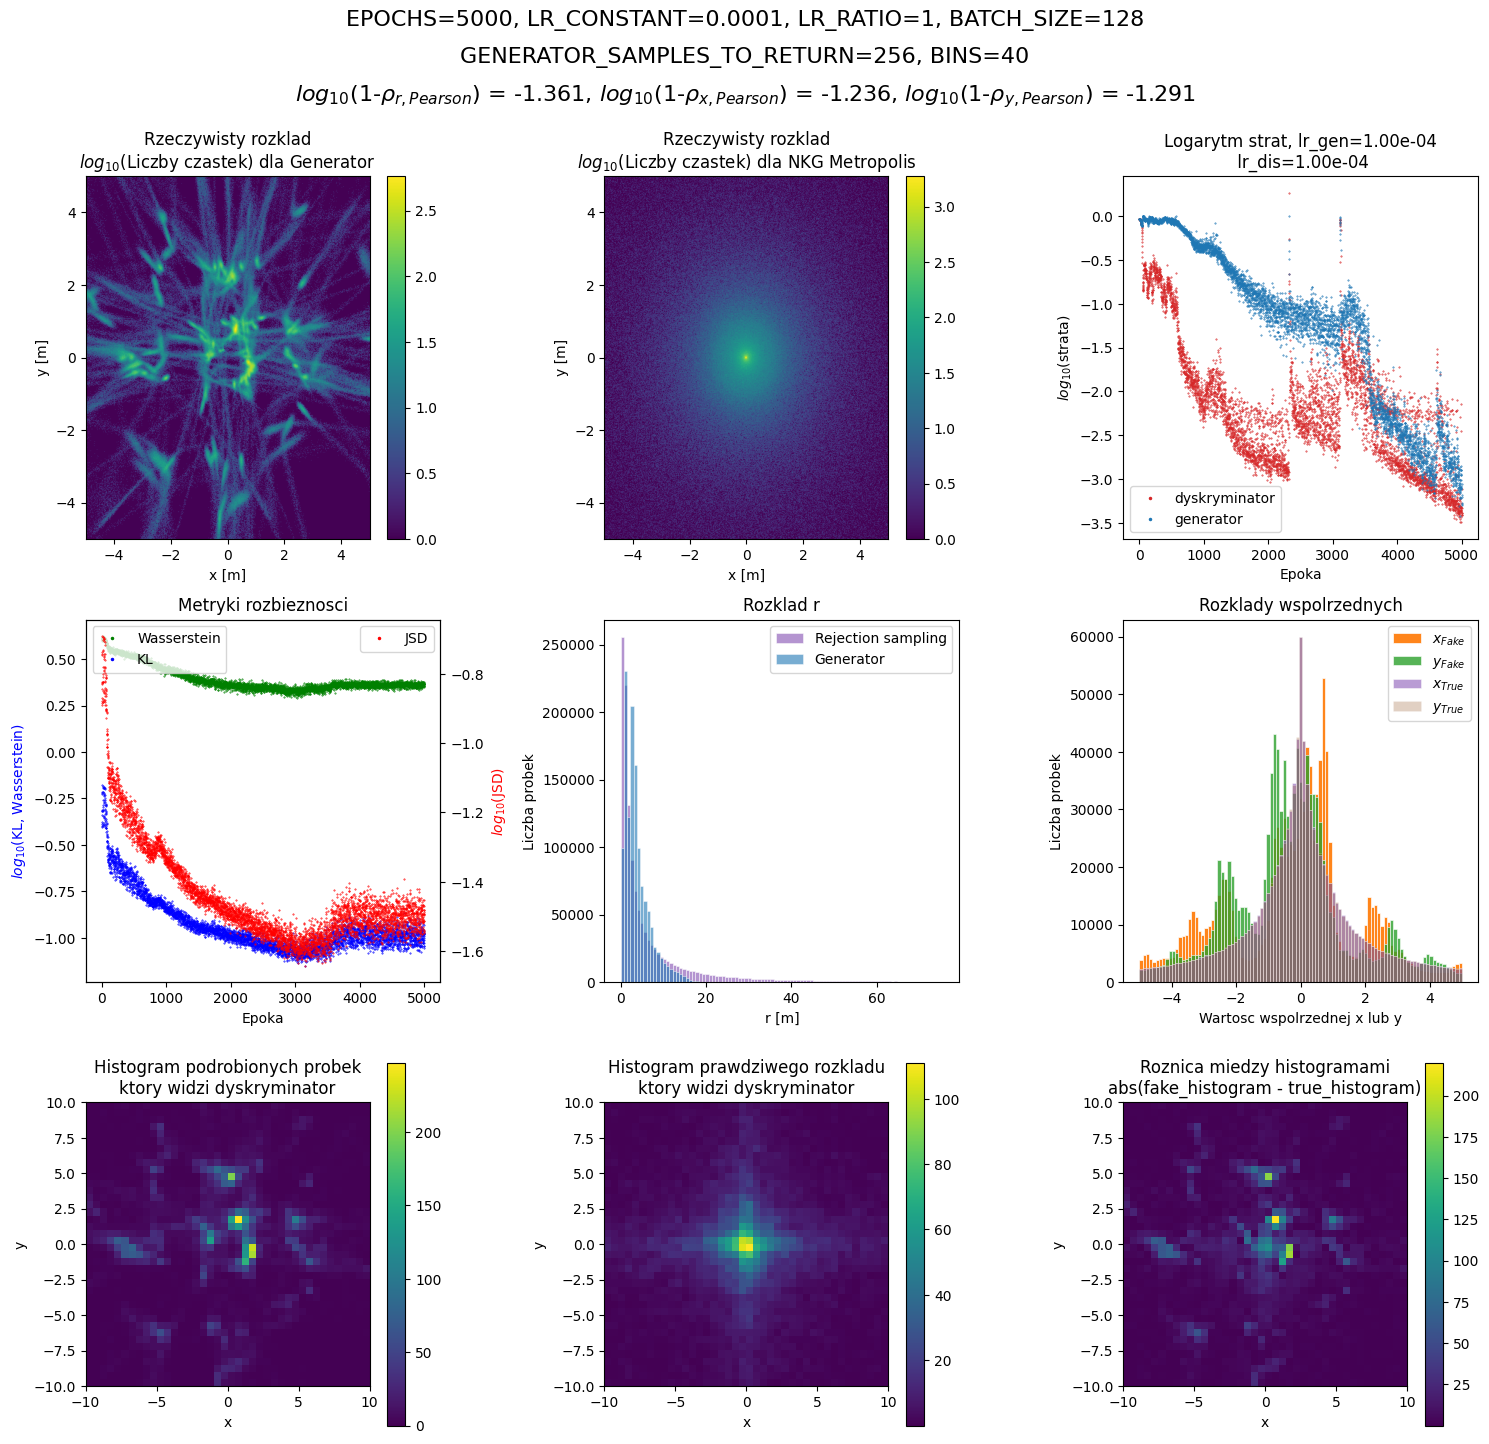

In [22]:
from concurrent.futures import ThreadPoolExecutor
import time

# Konfiguracja
BINS = 40
EPOCHS = 5_000 #* 800 epok / min
LR_CONSTANT = 1e-4
LR_RATIO = 1 # LR_DYSKR / LR_GEN
BATCH_SIZE = 128
NOISE_SIZE = 128
GENERATOR_SIDE = 16
GENERATOR_SAMPLES_TO_RETURN = GENERATOR_SIDE ** 2

# for LR_RATIO in 10 ** np.linspace(-6, 0, num=5):
torch.cuda.empty_cache()
torch.manual_seed(42)
np.random.seed(42)

x_kurtosis_history, y_kurtosis_history  = np.empty(EPOCHS), np.empty(EPOCHS)
x_skewness_history, y_skewness_history  = np.empty(EPOCHS), np.empty(EPOCHS)
x_stdev_history, y_stdev_history        = np.empty(EPOCHS), np.empty(EPOCHS)
x2_mean_history, y2_mean_history        = np.empty(EPOCHS), np.empty(EPOCHS)
generator_losses, discriminator_losses  = np.empty(EPOCHS), np.empty(EPOCHS)
KL, JSD, Wasserstein_distance           = np.empty(EPOCHS), np.empty(EPOCHS), np.empty(EPOCHS)
G_weight_change, D_weight_change        = np.empty(EPOCHS), np.empty(EPOCHS)

# transposed:  (Input_size - 1) × Stride - 2×Padding + Kernel_size + Output_padding
LAYERS_NUM = 4
INCREMENT_GENERATOR = (GENERATOR_SAMPLES_TO_RETURN - NOISE_SIZE) / LAYERS_NUM
generator_layers = [
    layer
    for i in range(LAYERS_NUM)
    for layer in [nn.LazyLinear(int(NOISE_SIZE + (i+1) * INCREMENT_GENERATOR)), nn.BatchNorm1d(int(NOISE_SIZE + (i+1) * INCREMENT_GENERATOR)) , nn.LeakyReLU(negative_slope=0.2)]
]
generator_layers.append(nn.LazyLinear(GENERATOR_SAMPLES_TO_RETURN))
generator = Generator(generator_layers, LR_CONSTANT)

# convolution: floor((Input_size + 2×Padding - Kernel_size) / Stride) + 1
LAYERS_NUM = 8
INCREMENT_DISCRIMINATOR = (GENERATOR_SAMPLES_TO_RETURN - 1) // LAYERS_NUM
discriminator_layers = [ 
    layer
    for i in range(LAYERS_NUM)
    for layer in [nn.LazyLinear(int(GENERATOR_SAMPLES_TO_RETURN - (i+1) * INCREMENT_DISCRIMINATOR)), nn.LeakyReLU(negative_slope=0.2)]
]
discriminator_layers.extend( [nn.LazyLinear(1)] )
discriminator_layers.insert(0, nn.Flatten())
discriminator = Discriminator(discriminator_layers, LR_CONSTANT * LR_RATIO)

generator.train()
generator.compile()
discriminator.train()
discriminator.compile()


def add_stats(data_tensor: torch.Tensor, epoch: int = None):
    tensor_view = data_tensor.view(BATCH_SIZE, -1, 2)
    means = tensor_view.mean(dim=1)  # (batch, 2)
    stds = tensor_view.std(dim=1)    # (batch, 2)
    squared_mean = torch.pow(tensor_view, 2).mean(dim=1)

    normalized = (tensor_view - means.unsqueeze(1)) / stds.unsqueeze(1)

    skewness = torch.pow(normalized, 3).mean(dim=1)
    kurtosis = torch.pow(normalized, 4).mean(dim=1) - 3

    if epoch is not None:
        x_kurtosis_history[epoch],  y_kurtosis_history[epoch]   = kurtosis.mean(dim=0).cpu().numpy()
        x_skewness_history[epoch],  y_skewness_history[epoch]   = skewness.mean(dim=0).cpu().numpy()
        x2_mean_history[epoch],     y2_mean_history[epoch]      = squared_mean.mean(dim=0).cpu().numpy()
        x_stdev_history[epoch],     y_stdev_history[epoch]      = stds.mean(dim=0).cpu().numpy()


def gather_stats(true_data, fake_data, epoch):
    true_data_np = true_data.reshape(-1, 1).cpu().detach().numpy()
    fake_data_np = fake_data.reshape(-1, 1).cpu().detach().numpy()

    progress = epoch / EPOCHS
    filled = int(200 * progress)
    bar = '█' * filled + '░' * (200 - filled)
    print(f'\rTrening [{bar}] ({progress*100:5.1f}%)', end='', flush=True)

    KL[epoch], JSD[epoch] = fast_kl_jsd_2d(true_data_np, fake_data_np)
    Wasserstein_distance[epoch] = stats.wasserstein_distance(fake_data_np.reshape(-1,), true_data_np.reshape(-1,))

    if epoch % 1_000 == 0 and epoch != 0:
        plot_basic_stats(generator_losses, discriminator_losses, KL, JSD, Wasserstein_distance, epoch, f'\nTrening_dla_{LR_RATIO=}_{epoch=}')


def create_noise_and_data():
    noise = torch.randn(BATCH_SIZE, NOISE_SIZE, device='cuda')
    data = get_2d_data(BATCH_SIZE * GENERATOR_SAMPLES_TO_RETURN)
    return noise, data


def calculate_weights(model: nn.Module):
    total_norm = 0.0
    for parameter in model.parameters():
        if parameter.grad is not None: # kiedy mialoby byc None?
            total_norm += parameter.grad.norm(2).item() ** 2

    return total_norm ** 0.5


def hard_histogram(points, min_value, max_value, bins):
    with torch.no_grad():
        x_indices = ((points[:, :, 0] - min_value) / (max_value - min_value) * bins).long().clamp(0, bins-1)
        y_indices = ((points[:, :, 1] - min_value) / (max_value - min_value) * bins).long().clamp(0, bins-1)
        
        flat_indices = y_indices * bins + x_indices
        
        batch_offsets = torch.arange(BATCH_SIZE, device=points.device).unsqueeze(1) * (bins * bins)
        flat_indices_with_batch = (flat_indices + batch_offsets).flatten()
        
        all_hists = torch.bincount(flat_indices_with_batch, minlength=BATCH_SIZE * bins * bins)
        
        return all_hists.reshape(BATCH_SIZE, bins, bins).float()
    
def soft_histogram(points, min_value, max_value, bins, sigma=None):
    bin_width = (max_value - min_value) / bins
    sigma = sigma or 0.4 * bin_width
    
    centers = min_value + (torch.arange(bins, device=points.device) + 0.5) * bin_width
    
    cy, cx = torch.meshgrid(centers, centers, indexing='ij')  # (bins, bins)
    
    dx = (points[:, :, 0:1, None] - cx[None, None, :, :]) / sigma
    dy = (points[:, :, 1:2, None] - cy[None, None, :, :]) / sigma
    
    w = torch.exp(-0.5 * (dx*dx + dy*dy))
    return w.sum(dim=1, keepdim=True)


def add_weights(epoch: int):
    G_weight_change[epoch] = calculate_weights(generator)
    D_weight_change[epoch] = calculate_weights(discriminator)

noise, data = create_noise_and_data()
lr_scale_discriminator, lr_scale_generator = None, None


start_time = time.time()
with ThreadPoolExecutor(max_workers=4) as executor: #* Potem zkompressuj i przyspiesz cala konstrukcje
    for epoch in range(EPOCHS):
        fake_data = generator.layers(noise).reshape(BATCH_SIZE, -1, 2).detach()
        add_stats(fake_data, epoch)
        fake_histogram = soft_histogram(fake_data, min_value=-5, max_value=5, bins=BINS)

        true_data = torch.FloatTensor(data).reshape(BATCH_SIZE, -1, 2).cuda()
        add_stats(true_data)
        true_histogram = soft_histogram(true_data, min_value=-5, max_value=5, bins=BINS)
        
        discriminator_losses[epoch] = discriminator.training_step(true_histogram, fake_histogram)
        
        generator_losses[epoch] = generator.training_step(noise)
        
        future_stats = executor.submit(gather_stats, true_data, fake_data, epoch)
        future_weights = executor.submit(add_weights, epoch)
        noise, data = executor.submit(create_noise_and_data).result()

bar = '█' * 200
print(f'\rTrening [{bar}] {epoch:4d}/{EPOCHS}\n({100:5.1f}%)\n', end='', flush=True)
print(f'\n{EPOCHS / (time.time() - start_time) * 60:.0f} Epok / min')

plot_basic_stats(generator_losses, discriminator_losses, KL, JSD, Wasserstein_distance, EPOCHS, f'\nTrening_dla_{LR_RATIO=}')

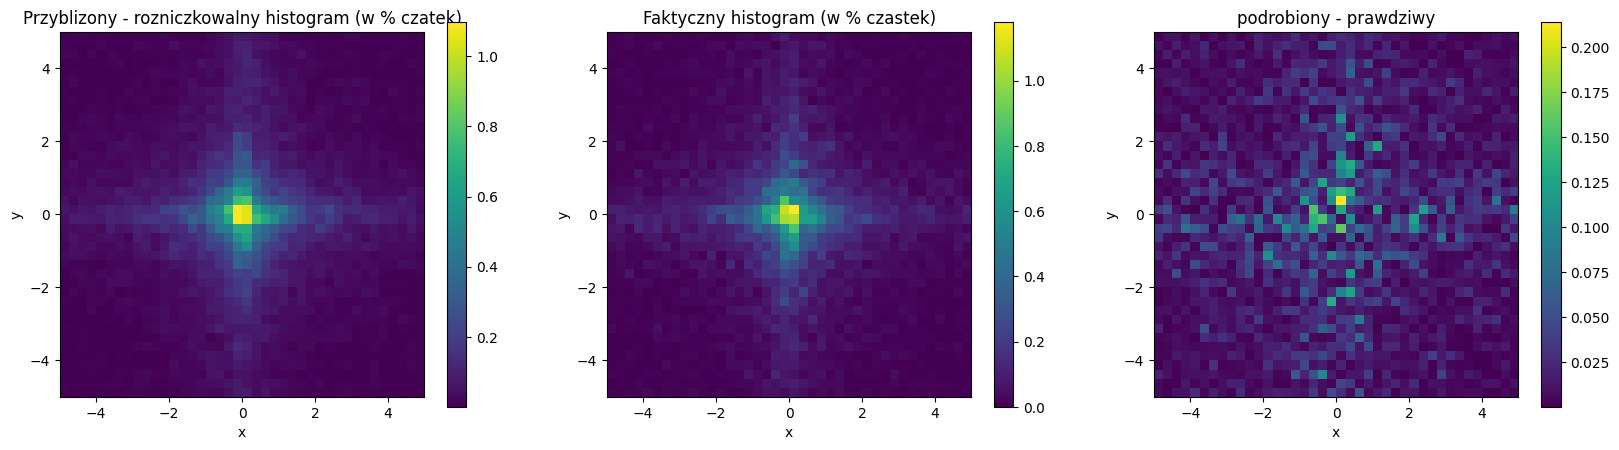

In [26]:
# Porownac funkcje dajaca histogram

BINS = 40

def hard_histogram(points, min_value, max_value, bins):
    x_values = points[:, :, 0].cpu().numpy().reshape(-1,)
    y_values = points[:, :, 1].cpu().numpy().reshape(-1,)

    return np.histogram2d(x_values, y_values, bins=bins, range=[[min_value, max_value], [min_value, max_value]])


def soft_histogram(points, min_value, max_value, bins, sigma = None):
    bin_width = (max_value - min_value) / bins
    sigma = sigma or 0.4 * bin_width

    points[points < min_value] = min_value * 100
    points[points > max_value] = max_value * 100
    
    centers = min_value + (torch.arange(bins, device=points.device) + 0.5) * bin_width
    
    cy, cx = torch.meshgrid(centers, centers, indexing='ij')  # (bins, bins)
    
    dx = (points[:, :, 0:1, None] - cx[None, None, :, :]) / sigma
    dy = (points[:, :, 1:2, None] - cy[None, None, :, :]) / sigma
    
    w = torch.exp(-0.5 * (dx*dx + dy*dy))
    return w.sum(dim=1, keepdim=True)


min_val = -5
max_val = 5

data = torch.Tensor( get_2d_data(BATCH_SIZE * GENERATOR_SAMPLES_TO_RETURN).reshape(BATCH_SIZE, -1, 2) ).cuda()
soft = soft_histogram(data, min_value=min_val, max_value=max_val, bins=BINS).sum(dim=0).squeeze().cpu().numpy()
hard, _, _ = hard_histogram(data, min_value=min_val, max_value=max_val, bins=BINS)

soft = soft * 100 / np.sum(soft)
hard = hard * 100 / np.sum(hard)

im, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

ax1.set_title('Przyblizony - rozniczkowalny histogram (w % czatek)')
im = ax1.imshow(soft, extent=[min_val, max_val, min_val, max_val])
ax1.set_xlabel('x')
ax1.set_ylabel('y')
plt.colorbar(im, ax=ax1)


ax2.set_title('Faktyczny histogram (w % czastek)')
im = ax2.imshow(hard, extent=[min_val, max_val, min_val, max_val])
ax2.set_xlabel('x')
ax2.set_ylabel('y')
plt.colorbar(im, ax=ax2)


ax3.set_title('podrobiony - prawdziwy')
im = ax3.imshow(np.abs(soft - hard), extent=[min_val, max_val, min_val, max_val])
ax3.set_xlabel('x')
ax3.set_ylabel('y')
plt.colorbar(im, ax=ax3)

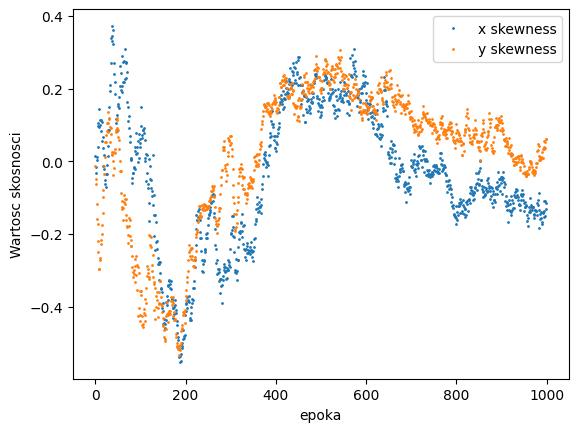

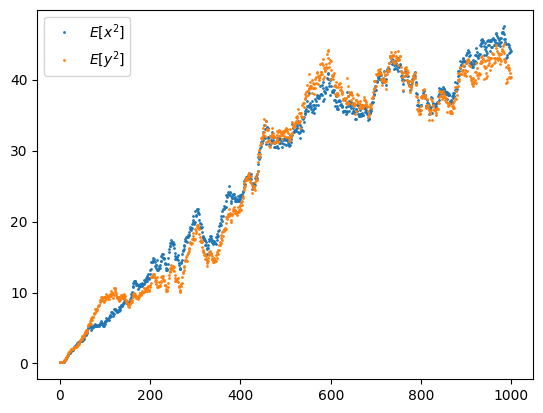

In [ ]:
plt.plot(x_skewness_history, 'o', markersize=1, label='x skewness')
plt.plot(y_skewness_history, 'o', markersize=1, label='y skewness')
plt.xlabel('epoka')
plt.ylabel('Wartosc skosnosci')
plt.legend()
plt.show()

plt.plot(x2_mean_history, 'o', markersize=1, label=r'$E[x^2]$')
plt.plot(y2_mean_history, 'o', markersize=1, label=r'$E[y^2]$')
plt.legend()

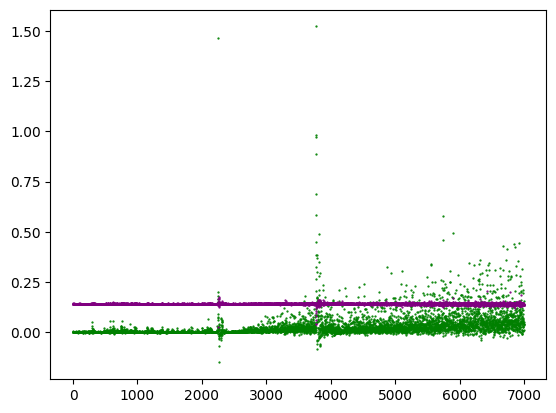

In [ ]:
plt.plot(np.log10( generator_losses[3_000:] ), 'o', markersize=0.6, color='green')
plt.plot(np.log10( discriminator_losses[3_000:] ), 'o', markersize=0.6, color='purple')

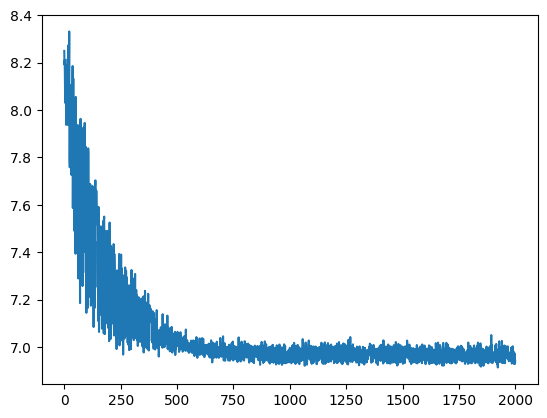

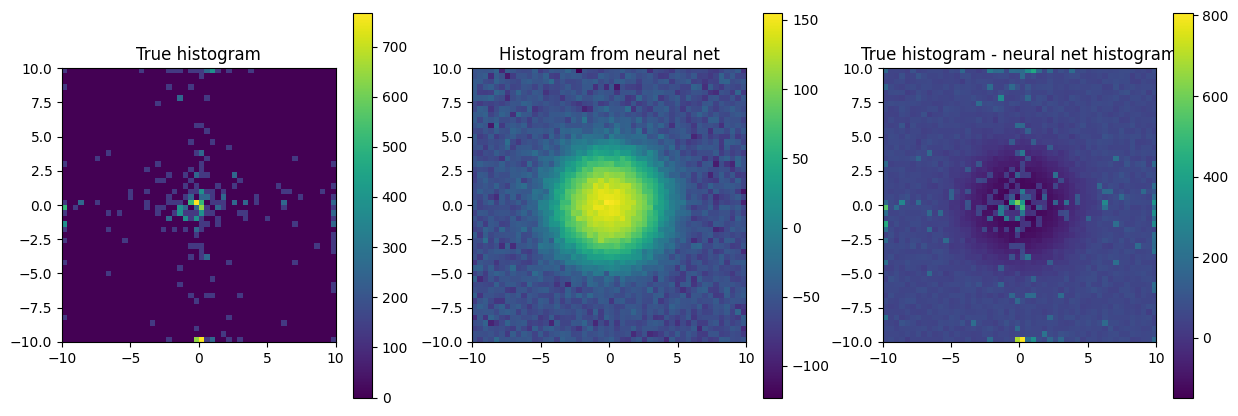

In [ ]:
import torch.nn.functional as F

LR_CONSTANT = 1e-5
GENERATOR_SAMPLES_TO_RETURN = 256
EPOCHS = 2_000
BINS = 50

class Exp(nn.Module):
    def forward(self, x):
        return torch.exp(x)

class Threshold(nn.Module):
    def __init__(self, min_val=0, max_val=None):
        super().__init__()
        self.min_val = min_val
        self.max_val = max_val
    
    def forward(self, x):
        return torch.clamp(x, min=self.min_val, max=self.max_val)


class Histogram_maker(nn.Module):
    def __init__(self, layers: list, lr: float = 1e-5):
        super().__init__()
        self.layers = nn.Sequential(*layers)
        self.optim = optim.Adam(self.parameters(), lr, betas=(0.5, 0.999)) # consider other options
        self.loss = nn.KLDivLoss(reduction="batchmean")
        self.to('cuda')

    def training_step(self, data, histogram_label):
        self.zero_grad()

        prediction = self.layers(data.squeeze()).reshape(-1, BINS, BINS)
        pred_probs = F.log_softmax(prediction.view(prediction.size(0), -1), dim=1)
        true_probs = histogram_label.view(histogram_label.size(0), -1)
        true_probs = true_probs / true_probs.sum(dim=1, keepdim=True)

        gen_loss = self.loss(pred_probs, true_probs)
        gen_loss.backward()
        
        gen_loss = gen_loss.detach().cpu().item()
        self.optim.step()
        return gen_loss

histogram_net = [
    layers
    for num in np.linspace(2, BINS * BINS, num=10, dtype=int, endpoint=True)
    for layers in [nn.LazyLinear(num), nn.BatchNorm1d(num)]
]
histogram_maker = Histogram_maker(histogram_net, LR_CONSTANT)

loss = np.empty(EPOCHS)
uniform_dist = torch.distributions.Uniform(-10, 10)

for epoch in range(EPOCHS): # Wchodzi tam 128 x 128 x 2
    data = uniform_dist.sample((BATCH_SIZE, 1, 2)).cuda()
    true_histogram = make_histogram(data, min_value=-10, max_value=10, bins=BINS).cuda()
    loss[epoch] = histogram_maker.training_step(data, true_histogram)

plt.plot(loss)

comparison_data = torch.Tensor( get_2d_data(BATCH_SIZE * GENERATOR_SAMPLES_TO_RETURN)).view(BATCH_SIZE, 1, GENERATOR_SAMPLES_TO_RETURN // 2, 2).cuda()
fake_histogram = histogram_maker.layers(comparison_data.view(-1, 2)).detach().sum(dim=0).cpu().view(BINS, BINS).numpy()
true_histogram = make_histogram(comparison_data, min_value=-10, max_value=10, bins=BINS).sum(dim=0).cpu().numpy()

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

ax1.set_title('True histogram')
im = ax1.imshow(true_histogram, extent=[-10, 10, -10, 10])
plt.colorbar(im, ax=ax1)

ax2.set_title('Histogram from neural net')
im = ax2.imshow(fake_histogram, extent=[-10, 10, -10, 10])
plt.colorbar(im, ax=ax2)

ax3.set_title('True histogram - neural net histogram')
im = ax3.imshow(true_histogram - fake_histogram, extent=[-10, 10, -10, 10])
plt.colorbar(im, ax=ax3)